##### <center>Predicting Hazelnut Biomass using Image-derived Canopy Metrics and Random Forest</center>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from fastai.tabular.core import Categorify, FillMissing, cont_cat_split, TabularPandas
from fastbook import cluster_columns
import math

c:\Users\exx\.conda\envs\fastai_dl\Lib\site-packages\fastbook\__init__.py:11: UserWarning: Missing `ipywidgets` - please install it
  except ModuleNotFoundError: warn("Missing `ipywidgets` - please install it")
c:\Users\exx\.conda\envs\fastai_dl\Lib\site-packages\fastbook\__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


##### <center>Load and Pre-process the Data</center>

In [2]:
data = pd.read_csv("C:\\Users\\exx\\Downloads\\Rosemount_CanopyMetrics_Final.csv", low_memory=False)
data.columns

Index(['site', 'type', 'treeID', 'n_trees', 'diameter', 'area', 'volume',
       'width', 'length', 'diagonal_width', 'diagonal_length', 'biomass'],
      dtype='object')

In [3]:
# drop na from the data
data = data.dropna()

# subset only LiDAR type 
data = data[data['type'] == 'LiDAR']

# remmove descritpive columns
data = data.drop(columns=['site', 'type', 'treeID', 'n_trees'])

In [4]:
dependent_variable = 'biomass'
data[dependent_variable] = np.log(data[dependent_variable]) # taking log of dep var because error metric is RMSLE between actual and predicted biomass

In [5]:
# split into train and test sets
df, df_test = train_test_split(data, test_size=0.2)

In [6]:
# store indices in list
idx = list(df.index)

# set cond to subset first 805% of indices
cond = df.index.isin(idx[:int(len(idx)*0.8)])
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var = dependent_variable)
to = TabularPandas(df, procs, cat, cont, y_names=dependent_variable, splits = splits)

In [7]:
len(to.train), len(to.valid)

(22, 6)

In [8]:
to.show(3) # shows embeddings for categorical values

,diameter,area,volume,width,length,diagonal_width,diagonal_length,biomass
26,3.190728,5.006864,5.539432,3.109818,2.41986,3.147406,2.566449,2.884801
21,2.468909,3.729064,5.634546,2.389860,2.34486,2.390613,2.349338,3.030134
30,3.383458,6.987432,9.075624,3.234810,3.26980,3.345883,3.275910,3.280911


In [9]:
to.items.head(3) # shows embedded values for categorical variables

,diameter,area,volume,width,length,diagonal_width,diagonal_length,biomass
26,3.190728,5.006864,5.539432,3.109818,2.41986,3.147406,2.566449,2.884801
21,2.468909,3.729064,5.634546,2.389860,2.34486,2.390613,2.349338,3.030134
30,3.383458,6.987432,9.075624,3.234810,3.26980,3.345883,3.275910,3.280911


##### <center>Create the Random Forest</center>

In [10]:
def randomForest(xs, y, n_estimators=150, max_samples=len(to.train),
                  max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                max_samples=max_samples, max_features=max_features,
                                min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [11]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y
m = randomForest(xs, y)

In [12]:
# print feature names in random forest model
print(m.feature_names_in_)

['diameter' 'area' 'volume' 'width' 'length' 'diagonal_width' 'diagonal_length']


In [13]:
# functions for calculating rmse
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [14]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.247412, 0.183054)

In [15]:
# set feature names for each tree in the random forest model
for est in m.estimators_:
    est.feature_names_in_ = m.feature_names_in_

In [16]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds.shape

(150, 6)

In [17]:
r_mse(preds.mean(0), valid_y)

0.183054

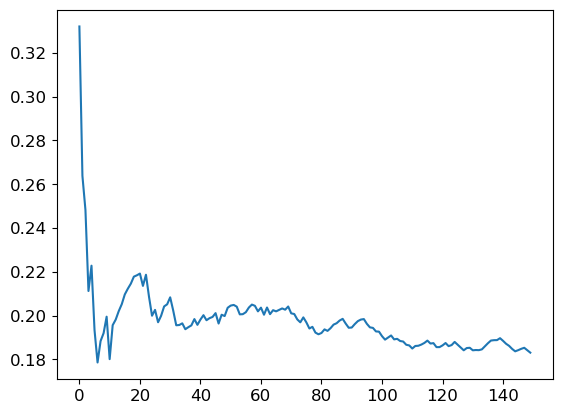

In [32]:
# plot mean prediction error of each estimator (decision tree) in the random forest
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(150)]);

In [19]:
# out-of-bag rmse error
r_mse(m.oob_prediction_, y)

0.293831

##### <center>Tree Variance for Prediction Confidence</center>

In [20]:
# std. dev. gives model confidence
preds_std = preds.std(0)
preds_std[:5]

array([0.34934616, 0.24267926, 0.08098501, 0.29202669, 0.10841741])

##### <center>Feature Importance</center>

In [21]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [22]:
feature_importance = rf_feat_importance(m, xs)
feature_importance[:10]

,cols,imp
2,volume,0.348295
0,diameter,0.168031
4,length,0.160000
1,area,0.157850
6,diagonal_length,0.151885
5,diagonal_width,0.007272
3,width,0.006667


In [23]:
def plot_feature_importance(feature_importance):
    return feature_importance.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

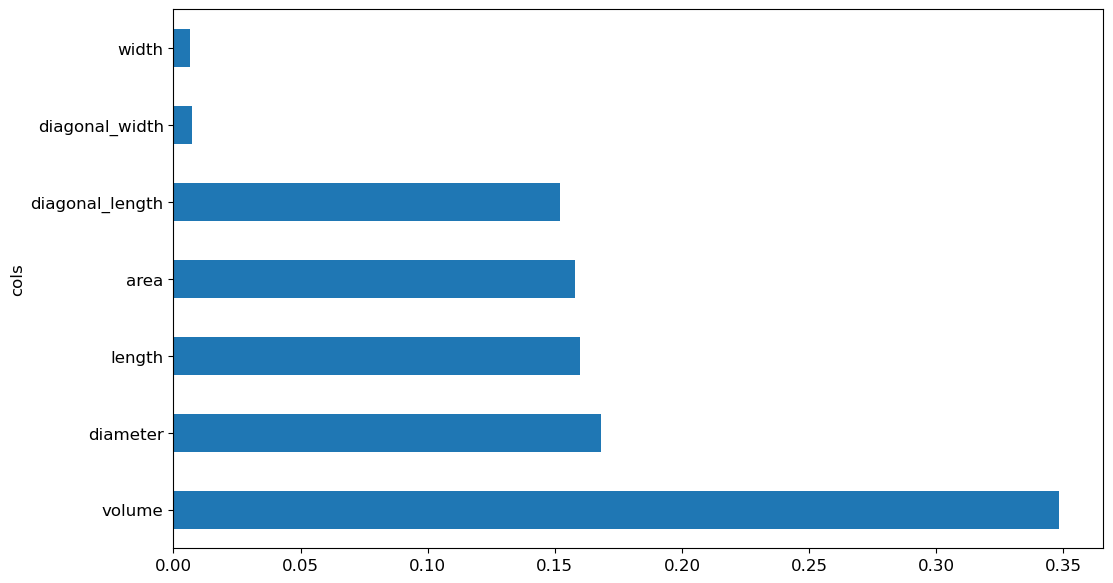

In [24]:
plot_feature_importance(feature_importance[:30]);

##### <center>Removing Low-importance Variables</center>

In [33]:
to_keep = feature_importance[feature_importance.imp>0.05].cols
len(to_keep)

5

In [34]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m_imp = randomForest(xs_imp, y)
m_rmse(m_imp, xs_imp, y), m_rmse(m_imp, valid_xs_imp, valid_y)

(0.243901, 0.188799)

In [35]:
len(xs.columns), len(xs_imp.columns)

(7, 5)

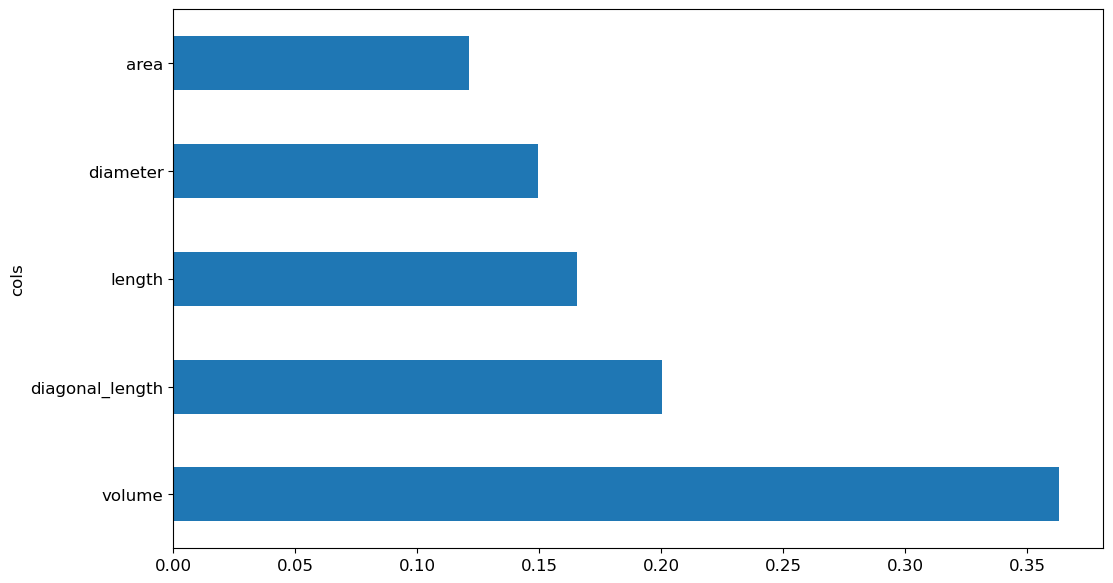

In [36]:
plot_feature_importance(rf_feat_importance(m_imp, xs_imp));

##### <center>Removing Redundant Features using Out-of-bag Error</center>

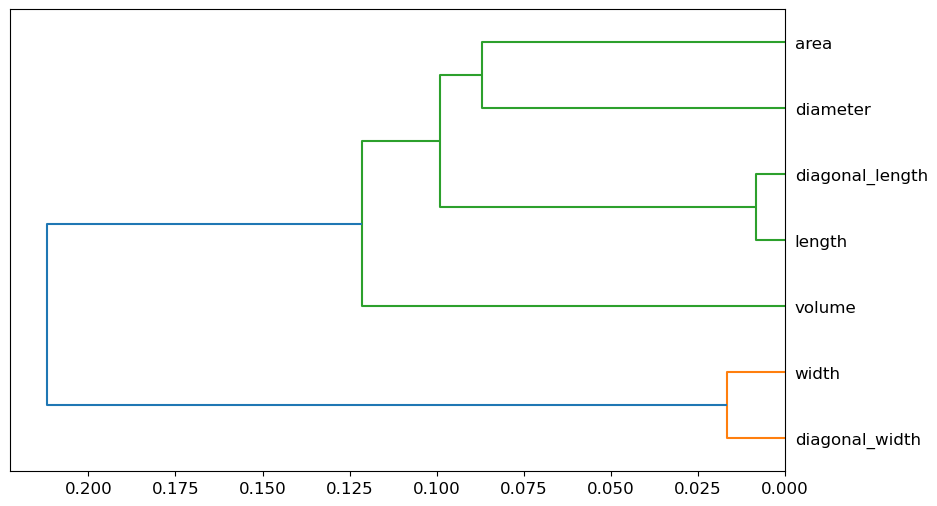

In [29]:
cluster_columns(xs_imp)

In [39]:
# OOB score measures  model performance. Score of 1.0 for perfect model, score of 0 for random model
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
                                  max_samples = len(to.train), max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [45]:
m.feature_names_in_

array(['diameter', 'area', 'volume', 'width', 'length', 'diagonal_width', 'diagonal_length'], dtype=object)

In [40]:
get_oob(xs_imp)

-0.07568954704121711

In [46]:
# remove each potentially redundant variable, one at a time, and check oob score
{c:get_oob(xs_imp.drop(c, axis=1)) for c in m.feature_names_in_}

KeyError: "['width'] not found in axis"

In [ ]:
# now try dropping multiple variables. for each group of redundant variables, remove variable with lowest OOB score. 
to_drop = ['var1', 'var2']
get_oob(xs_imp.drop(to_drop, axis=1))

In [ ]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

# save final data to pickle
('path_to_train_pickle_file.pkl').fastai.save(xs_final)
('path_to_valid_pickle_file.pkl').fastai.save(valid_xs_final)

In [ ]:
# check RMSE again to ensure accuracy hasn't substantially changed
m = randomForest(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

##### <center>Plot Partial Dependence of Most Important Variables</center>

In [ ]:
# look at feature importance plot above and store most important variables in a list
imp_vars = ['var3', 'var4', 'var5']

from sklearn.inspection import plot_partial_dependence
fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, imp_vars, grid_resolution=20, ax=ax);

##### <center>Use Tree Interpreters to Identify Factors that Influence Prediction</center>

In [ ]:
%pip install treeinterpreter
%pip install waterfallcharts
import treeinterpreter
import waterfallcharts

In [ ]:
row = valid_xs_final.iloc[:5]
prediction, bias, contributions = treeinterpreter.predict(m, row.values)

In [ ]:
# look at just first row results
prediction[0], bias[0], contributions[0].sum()

In [ ]:
# plot contributions of variables using waterfall chart
waterfallcharts.waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, rotation_value=45, formatting='{:,.3f}')

##### <center>Compare Neural Network against Random Forest</center>